# Baseline models

In [536]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import LSTM, Convolution1D, GlobalAveragePooling1D, Dense, Dropout
import keras_tuner as kt

from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import RandomizedSearchCV

from sklearn import preprocessing

# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.9.2


In [537]:
train_data_df = pd.read_csv('../data_analysis/fd003/fd003-scaled_train.csv', sep=' ')
test_data_df = pd.read_csv('../data_analysis/fd003/fd003-scaled_test.csv', sep=' ')

train_labels_df = pd.read_csv('../data_analysis/fd003/fd003-training_labels.csv', sep=' ')
test_labels_df = pd.read_csv('../data_analysis/fd003/fd003-testing_labels.csv', sep=' ')
test_labels_at_break_df = pd.DataFrame(pd.read_csv('../TED/CMAPSSData/RUL_FD003.txt', sep=' ', header=None)[0])
test_labels_at_break_df.columns = ['RUL']

In [538]:
test_at_break_df = test_data_df.groupby(['ID'], sort=False).last().reset_index()
train_labels_df = train_labels_df.clip(upper = 125)
# test_labels_df = test_labels_df.clip(upper = 125)

### Windows extraction

In [539]:
def get_windows(data_df, labels_df, window_length, mode = 'train'):

    if mode == 'train':

        labels_df['ID'] = data_df['ID']

        data_groupby = data_df.groupby('ID', sort=False)
        labels_groupby = labels_df.groupby('ID', sort=False)

        val_indices = np.random.choice(len(data_groupby), size = int(0.2 * len(data_groupby)))

        tr_data_eng_arr = []
        tr_labels_eng_arr = []

        val_data_eng_arr = []
        val_labels_eng_arr = []

        for i in range(len(data_groupby)):
            if i in val_indices:
                val_data_eng_arr.append(data_groupby.get_group(i+1))
            else:
                tr_data_eng_arr.append(data_groupby.get_group(i+1))

        for i in range(len(labels_groupby)):
            if i in val_indices:
                val_labels_eng_arr.append(labels_groupby.get_group(i+1))
            else:
                tr_labels_eng_arr.append(labels_groupby.get_group(i+1))

        tr_data_windows = []
        tr_label_windows = []
        for index in range(len(tr_data_eng_arr)):
            tr_data_arr = tr_data_eng_arr[index].to_numpy()
            tr_labels_arr = tr_labels_eng_arr[index].to_numpy()
            if tr_data_arr.shape[0] - window_length + 1 > 0:
                for t in range(tr_data_arr.shape[0] - window_length + 1):
                    tr_data_windows.append(tr_data_arr[t:t+window_length, :])
                    tr_label_windows.append(tr_labels_arr[t+window_length - 1])

        val_data_windows = []
        val_label_windows = []
        for index in range(len(val_data_eng_arr)):
            val_data_arr = val_data_eng_arr[index].to_numpy()
            val_labels_arr = val_labels_eng_arr[index].to_numpy()
            if val_data_arr.shape[0] - window_length + 1 > 0:
                for t in range(val_data_arr.shape[0] - window_length + 1):
                    val_data_windows.append(val_data_arr[t:t+window_length, :])
                    val_label_windows.append(val_labels_arr[t+window_length - 1])

        return np.array(tr_data_windows), np.array(tr_label_windows), np.array(val_data_windows), np.array(val_label_windows)

    else:

        labels_df['ID'] = data_df['ID']

        data_groupby = data_df.groupby('ID', sort=False)
        labels_groupby = labels_df.groupby('ID', sort=False)
        data_eng_arr = []
        labels_eng_arr = []

        for i in range(len(data_groupby)):
            data_eng_arr.append(data_groupby.get_group(i+1))

        for i in range(len(labels_groupby)):
            labels_eng_arr.append(labels_groupby.get_group(i+1))

        data_windows = []
        label_windows = []
        for index in range(len(data_eng_arr)):
            data_arr = data_eng_arr[index].to_numpy()
            labels_arr = labels_eng_arr[index].to_numpy()
            if data_arr.shape[0] - window_length + 1 > 0:
                data_windows.append(data_arr[-window_length:, :])
                label_windows.append(labels_arr[-1, 0])

        return np.array(data_windows), np.array(label_windows)

### Divide train set between train and validation sets

In [540]:
train_labels_df['ID'] = train_data_df['ID']

In [541]:
train_groupby_df = train_data_df.groupby(['ID'], sort = False)
train_labels_groupby_df = train_labels_df.groupby(['ID'], sort = False)
val_indices = np.random.choice(len(train_groupby_df), size = int(0.2 * len(train_groupby_df)))

train_labels_df = train_labels_df['RUL']

val_arr = []
train_set_arr = []
val_labels_arr = []
train_set_labels_arr = []

for i in range(len(train_groupby_df)):
    if i in val_indices:
        val_arr.append(train_groupby_df.get_group(i+1))
        val_labels_arr.append(train_labels_groupby_df.get_group(i+1)['RUL'])
    else:
        train_set_arr.append(train_groupby_df.get_group(i+1))
        train_set_labels_arr.append(train_labels_groupby_df.get_group(i+1)['RUL'])

val_set_df = val_arr[0]
val_labels_df = val_labels_arr[0]
for i in range(1, len(val_arr)):
    val_set_df = pd.concat([val_set_df, val_arr[i]])
    val_labels_df = pd.concat([val_labels_df, val_labels_arr[i]])

train_set_df = train_set_arr[0]
train_set_labels_df = train_set_labels_arr[0]
for i in range(1, len(train_set_arr)):
    train_set_df = pd.concat([train_set_df, train_set_arr[i]])
    train_set_labels_df = pd.concat([train_set_labels_df, train_set_labels_arr[i]])

train_set = train_set_df.values
train_set_labels = train_set_labels_df.values
val_set = val_set_df.values
val_labels = val_labels_df.values
val_labels = np.expand_dims(val_labels, axis = 1)
train_set_labels = np.expand_dims(train_set_labels, axis = 1)
train_labels = np.expand_dims(train_labels_df.values, axis = 1)

In [542]:
ms_used = train_data_df.columns[2:]
ms_used

Index(['SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure7',
       'SensorMeasure8', 'SensorMeasure9', 'SensorMeasure11',
       'SensorMeasure12', 'SensorMeasure13', 'SensorMeasure14',
       'SensorMeasure15', 'SensorMeasure17', 'SensorMeasure20',
       'SensorMeasure21'],
      dtype='object')

## Survival Analysis: KaplanMeierFitter and CoxPHFitter

### Kaplan Meier Fitter

In [543]:
km_train = train_data_df.copy()
km_test = test_data_df.copy()
km_train['Event Observed'] = 1
km_test['Event Observed'] = 0

km_total = pd.concat([km_train, km_test])

<AxesSubplot:xlabel='timeline'>

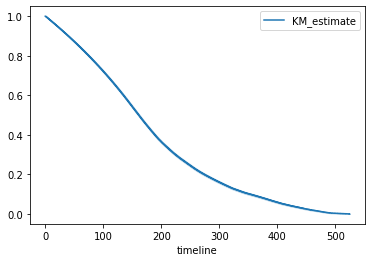

In [544]:
kmf = KaplanMeierFitter()
kmf.fit(durations = km_total['Cycle'], event_observed = km_total['Event Observed'])
kmf.plot_survival_function()

In [545]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)

161.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                   160.0                   163.0


### Cox Proportional Hazard

In [546]:
cox_train = train_data_df.copy()
cox_test = test_data_df.copy()
cox_train['Event Observed'] = 1
cox_test['Event Observed'] = 0

cox_total = pd.concat([cox_train, cox_test])

In [547]:
cph = CoxPHFitter()
cph.fit(cox_total, duration_col = 'Cycle', event_col = 'Event Observed')
cph.print_summary()

/Users/henry/.virtualenvs/tf-m1/lib/python3.9/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 41316 total observations, 16596 right-censored observations>
             duration col = 'Cycle'
                event col = 'Event Observed'
      baseline estimation = breslow
   number of observations = 41316
number of events observed = 24720
   partial log-likelihood = -224282.29
         time fit was run = 2022-08-25 23:41:48 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
ID                0.01       1.01       0.00             0.00             0.01                 1.00                 1.01
SensorMeasure2   -1.20       0.30       0.08            -1.36            -1.04                 0.26                 0.35
SensorMeasure3   -0.34       0.71       0.08            -0.49            -0.19                 0.61                 0.83
SensorMeasure4   -0.19       0.83       0.09            -0.36            -0.02                 0.70                 0.98
SensorMeasure7   -1.66       0.19       0.26            -2.17            -1.14                 0.11                 0.32
SensorMeasure8   -0.55       0.58       0.26            -1.06            -0.04                 0.35                 0.96
SensorMeasure9   -1.71       0.18       0.23            -2.15            -1.26                 0.12                 0.28
SensorMeasure11  -0.37       0.69       0.09            -0.55            -0.20                 0.58                 0.82
SensorMeasure12   2.72      15.12       0.27             2.19             3.24                 8.95                25.55
SensorMeasure13   1.09       2.97       0.26             0.58             1.59                 1.79                 4.92
SensorMeasure14  -6.35       0.00       0.22            -6.78            -5.92                 0.00                 0.00
SensorMeasure15   4.24      69.12       0.11             4.01             4.46                55.38                86.28
SensorMeasure17  -0.44       0.65       0.07            -0.58            -0.30                 0.56                 0.74
SensorMeasure20   0.60       1.82       0.10             0.40             0.80                 1.49                 2.22
SensorMeasure21   1.36       3.91       0.11             1.16             1.57                 3.18                 4.81

                  cmp to      z      p   -log2(p)
covariate                                        
ID                  0.00  23.34 <0.005     397.80
SensorMeasure2      0.00 -14.65 <0.005     159.04
SensorMeasure3      0.00  -4.43 <0.005      16.69
SensorMeasure4      0.00  -2.18   0.03       5.11
SensorMeasure7      0.00  -6.30 <0.005      31.62
SensorMeasure8      0.00  -2.12   0.03       4.86
SensorMeasure9      0.00  -7.50 <0.005      43.88
SensorMeasure11     0.00  -4.26 <0.005      15.60
SensorMeasure12     0.00  10.15 <0.005      77.97
SensorMeasure13     0.00   4.23 <0.005      15.36
SensorMeasure14     0.00 -28.91 <0.005     607.94
SensorMeasure15     0.00  37.45 <0.005    1017.18
SensorMeasure17     0.00  -6.14 <0.005      30.16
SensorMeasure20     0.00   5.91 <0.005      28.15
SensorMeasure21     0.00  12.90 <0.005     124.14
---
Concordance = 0.68
Partial AIC = 448594.58
log-likelihood ratio test = 20913.34 on 15 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

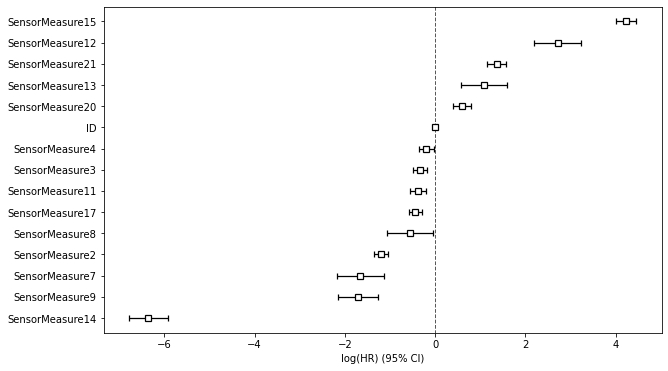

In [548]:
plt.subplots(figsize = (10, 6))
cph.plot()

## Random Forest Regressor

In [549]:
# train_data_df

In [550]:
window_length = 30
X_train, y_train, X_val, y_val = get_windows(train_data_df, train_labels_df, window_length, mode='train')
X_test, y_test = get_windows(test_data_df, test_labels_df, window_length, mode = 'test')

y_train = np.expand_dims(y_train, axis=1)
y_val = np.expand_dims(y_val, axis=1)
y_test = np.expand_dims(y_test, axis=1)

X_train = X_train[:,:,2:]
X_val = X_val[:,:,2:]
X_test = X_test[:,:,2:]

def mean_and_polynomial_fitting(data_set):
    mean_trends = []
    for window in data_set:
        sensor_means = np.mean(window, axis = 0)
        coefs = []
        for i in range(window.shape[-1]):
            coefs.append(np.polyfit(range(window.shape[0]), window[:,i], 1)[0])
        mean_trend = np.concatenate((sensor_means, np.array(coefs)), axis = 0)
        mean_trends.append(mean_trend)
    return np.array(mean_trends)

X_train = mean_and_polynomial_fitting(X_train)
X_val = mean_and_polynomial_fitting(X_val)
X_test = mean_and_polynomial_fitting(X_test)

scale = preprocessing.MinMaxScaler()
X_train = scale.fit_transform(X_train)
X_val = scale.fit_transform(X_val)
X_test = scale.fit_transform(X_test)

In [553]:
rf_param_grid = {
    'n_estimators': [15],
    'max_depth': [7, 8, 9, 10], 
    'min_samples_leaf': [35, 40, 45, 50]
    # 'max_features': ['log2', 'sqrt', None], 
    }

rf = RandomForestRegressor(random_state=42)
rand_search_rf = RandomizedSearchCV(estimator = rf, param_distributions = rf_param_grid, cv = 3, n_jobs = 1, verbose = 3, return_train_score=True)
rand_search_rf.fit(X_train, y_train.squeeze())
predictions_rf = rand_search_rf.predict(X_test).round()
rmse = np.sqrt(mean_squared_error(y_test.squeeze(), predictions_rf))
print("RMSE: " + str(rmse)) 

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END max_depth=8, min_samples_leaf=45, n_estimators=15;, score=(train=0.958, test=0.866) total time=   1.3s
[CV 2/3] END max_depth=8, min_samples_leaf=45, n_estimators=15;, score=(train=0.950, test=0.899) total time=   1.4s
[CV 3/3] END max_depth=8, min_samples_leaf=45, n_estimators=15;, score=(train=0.948, test=0.916) total time=   1.3s
[CV 1/3] END max_depth=10, min_samples_leaf=45, n_estimators=15;, score=(train=0.962, test=0.864) total time=   1.5s
[CV 2/3] END max_depth=10, min_samples_leaf=45, n_estimators=15;, score=(train=0.955, test=0.901) total time=   1.5s
[CV 3/3] END max_depth=10, min_samples_leaf=45, n_estimators=15;, score=(train=0.953, test=0.917) total time=   1.5s
[CV 1/3] END max_depth=8, min_samples_leaf=50, n_estimators=15;, score=(train=0.956, test=0.865) total time=   1.3s
[CV 2/3] END max_depth=8, min_samples_leaf=50, n_estimators=15;, score=(train=0.948, test=0.901) total time=   1.3s
[CV 3/3]

In [554]:
rand_search_rf.best_params_

{'n_estimators': 15, 'min_samples_leaf': 35, 'max_depth': 10}

In [431]:
# rf = RandomForestRegressor(n_estimators = 700, min_samples_leaf = 40, max_features = 'log2', max_depth = 10, random_state=42)
# rf.fit(train_data_df[ms_used].values, train_labels_df.values.squeeze())
# predictions_rf = rf.predict(test_at_break_df[ms_used].values).round()
# rmse = np.sqrt(mean_squared_error(test_labels_at_break_df.values, predictions_rf))
# print("RMSE: " + str(rmse)) 

# rf = RandomForestRegressor(n_estimators = 15, min_samples_leaf = 50, max_features = 'log2', max_depth = 8, random_state=42)
# rf.fit(X_train, y_train.squeeze())
# predictions_rf = rf.predict(X_test).round()
# rmse = np.sqrt(mean_squared_error(y_test.squeeze(), predictions_rf))
# print("RMSE: " + str(rmse)) 

## Gradient Boosting Regressor

In [432]:
gb_params = {
    'learning_rate': [0.001, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [7, 8, 9, 10], 
    'min_samples_leaf': [35, 40, 45, 50],
    'n_estimators': [15],
    }

gb = GradientBoostingRegressor()
rand_search_gb = RandomizedSearchCV(estimator = gb, param_distributions = gb_params, cv = 3, n_jobs = 1, verbose = 3, return_train_score=True)
rand_search_gb.fit(X_train, y_train.squeeze())

predictions_gb = rand_search_gb.predict(X_test).round()
print(rand_search_gb.best_params_)
rmse = np.sqrt(mean_squared_error(y_test.squeeze(), predictions_gb))
print("RMSE: " + str(rmse)) 

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END learning_rate=0.3, max_depth=9, min_samples_leaf=40, n_estimators=15;, score=(train=0.960, test=0.839) total time=   7.6s
[CV 2/3] END learning_rate=0.3, max_depth=9, min_samples_leaf=40, n_estimators=15;, score=(train=0.953, test=0.879) total time=   7.6s
[CV 3/3] END learning_rate=0.3, max_depth=9, min_samples_leaf=40, n_estimators=15;, score=(train=0.960, test=0.840) total time=   7.5s
[CV 1/3] END learning_rate=0.1, max_depth=8, min_samples_leaf=50, n_estimators=15;, score=(train=0.879, test=0.816) total time=   6.6s
[CV 2/3] END learning_rate=0.1, max_depth=8, min_samples_leaf=50, n_estimators=15;, score=(train=0.868, test=0.838) total time=   6.6s
[CV 3/3] END learning_rate=0.1, max_depth=8, min_samples_leaf=50, n_estimators=15;, score=(train=0.881, test=0.807) total time=   6.7s
[CV 1/3] END learning_rate=0.05, max_depth=10, min_samples_leaf=50, n_estimators=15;, score=(train=0.718, test=0.672) total time=

In [241]:
pd.DataFrame(train_labels_df)

,RUL
0,125
1,125
2,125
3,125
4,125
...,...
24716,3
24717,2
24718,1
24719,0


In [333]:
train_data_df[ms_used].values.shape, train_labels_df.values.shape

((24720, 14), (24721,))

In [336]:
# gb = GradientBoostingRegressor(n_estimators = 700, min_samples_leaf = 40, max_features = 'log2', max_depth = 8, learning_rate = 0.05, random_state=42)
# gb.fit(train_data_df[ms_used], train_labels_df)
# predictions_gb = gb.predict(test_data_df[ms_used]).round()
# rmse = np.sqrt(mean_squared_error(test_labels_df, predictions_gb))
# print("RMSE: " + str(rmse)) 

gb = GradientBoostingRegressor(n_estimators = 600, min_samples_leaf = 50, max_features = 'log2', max_depth = 7, learning_rate = 0.05, random_state=42)
gb.fit(X_train, y_train.squeeze())
predictions_gb = gb.predict(X_test).round()
rmse = np.sqrt(mean_squared_error(y_test.squeeze(), predictions_gb))
print("RMSE: " + str(rmse)) 

RMSE: 27.371152697685204


## Support Vector Regressor

In [ ]:
# svmr_params = {
#     'kernel': ['rbf', 'linear', 'poly'],
#     'C': [1, 2, 5, 10],
#     'epsilon': [0.1 * i for i in range(1, 6)]
# }

# svmr = SVR()
# rand_search_svmr = RandomizedSearchCV(estimator = svmr, param_distributions = svmr_params, cv = 3, n_jobs = 1, verbose = 3, return_train_score=True)
# rand_search_svmr.fit(train_data_df[ms_used].values, train_labels_df.values.squeeze())

# predictions_svmr = rand_search_svmr.predict(test_at_break_df[ms_used].values).round()
# print(rand_search_svmr.best_params_)
# rmse = np.sqrt(mean_squared_error(test_labels_at_break_df.values, predictions_svmr))
# print("RMSE: " + str(rmse)) 

In [120]:
best_svmr = SVR(C = 1, epsilon = 0.0)
best_svmr.fit(train_data_df[ms_used].values, train_labels_df.values.squeeze())
predictions_svmr = best_svmr.predict(test_at_break_df[ms_used].values).round()
rmse = np.sqrt(mean_squared_error(test_labels_at_break_df.values, predictions_svmr))
print("RMSE: " + str(rmse)) 

RMSE: 43.80096110302132


## Multi Layer Perceptron - Neural Network

In [157]:
mlp_model = Sequential()
mlp_model.add(Dense(64, activation = 'relu', input_dim = train_data_df.values.shape[-1]))
mlp_model.add(Dropout(0.25))
mlp_model.add(Dense(128, activation = 'relu'))
mlp_model.add(Dropout(0.25))
mlp_model.add(Dense(256, activation = 'relu'))
mlp_model.add(Dense(1))

mlp_model.compile(loss='mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate = 0.0005))   
mlp_history = mlp_model.fit(train_data_df.values, train_labels_df.values.squeeze(), epochs=50, batch_size = 256)

# TESTING FUNCTION
def testing(actual, pred, mode = 'Test'):
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mse)
    variance = r2_score(actual, pred)
    print(mode + ' set RMSE: ' + str(rmse) + ', R2: ' + str(variance))

train_mlp_pred = mlp_model.predict(train_data_df.values).round()
testing(train_labels_df.values.squeeze(), train_mlp_pred, 'Train')

test_mlp_pred = mlp_model.predict(test_data_df.values).round()
testing(test_labels_df.values.squeeze(), test_mlp_pred)

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-08-18 18:56:23.883578: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-18 18:56:23.883999: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [51]:
window_length = 20
mlp_tr_data, mlp_tr_labels, mlp_val_data, mlp_val_labels = get_windows(train_data_df, train_labels_df, window_length, mode='train')
mlp_test_data, mlp_test_labels = get_windows(test_data_df, test_labels_df, window_length, mode = 'test')

mlp_tr_data = mlp_tr_data.reshape(mlp_tr_data.shape[0], -1)
mlp_val_data = mlp_val_data.reshape(mlp_val_data.shape[0], -1)
mlp_test_data = mlp_test_data.reshape(mlp_test_data.shape[0], -1)

mlp_tr_labels = np.expand_dims(mlp_tr_labels, axis=1)
mlp_val_labels = np.expand_dims(mlp_val_labels, axis=1)
mlp_test_labels = np.expand_dims(mlp_test_labels, axis=1)

In [54]:
def mlp_model_builder(hp):

    hp_units1 = hp.Int('units1', min_value=32, max_value=128, step=32)
    hp_units2 = hp.Int('units2', min_value=32, max_value=128, step=32)
    hp_units3 = hp.Int('units3', min_value=32, max_value=128, step=32)

    hp_dropout = hp.Choice('dropout_rate', values=[0.1, 0.2, 0.3, 0.4])
    hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.005, 0.01, 0.05])

    mlp_model = Sequential()
    mlp_model.add(Dense(units = hp_units1, activation = 'relu', input_dim = mlp_tr_data.shape[1]))
    mlp_model.add(Dropout(hp_dropout))
    mlp_model.add(Dense(units = hp_units2, activation = 'relu'))
    mlp_model.add(Dropout(hp_dropout))
    mlp_model.add(Dense(units = hp_units3 , activation = 'relu'))
    mlp_model.add(Dropout(hp_dropout))
    mlp_model.add(Dense(1, activation = 'relu'))

    mlp_model.compile(optimizer=keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss=keras.losses.MeanSquaredError())

    return mlp_model

mlp_tuner = kt.BayesianOptimization(mlp_model_builder,
                                    objective='val_loss',
                                    max_trials = 9,
                                    directory='baseline_models',
                                    project_name='mlp')

INFO:tensorflow:Reloading Oracle from existing project baseline_models/mlp/oracle.json
INFO:tensorflow:Reloading Tuner from baseline_models/mlp/tuner0.json


In [36]:
mlp_tuner.search(train_set_df[ms_used].values, train_set_labels.squeeze(), epochs=100, validation_data = (val_set_df[ms_used].values, val_labels.squeeze()), batch_size = 256)
best_mlp_hps = mlp_tuner.get_best_hyperparameters(num_trials=1)[0]

best_mlp_model = mlp_tuner.hypermodel.build(best_mlp_hps)
mlp_history = best_mlp_model.fit(train_set_df[ms_used].values, train_set_labels.squeeze(), epochs=100, validation_data = (val_set_df[ms_used].values, val_labels.squeeze()), batch_size = 256)


Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
128               |128               |units1
32                |32                |units2
128               |32                |units3
0.1               |0.1               |dropout_rate
0.001             |0.001             |learning_rate

Epoch 1/100


2022-07-29 00:27:52.768364: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


ValueError: in user code:

    File "/Users/henry/.virtualenvs/tf-m1/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/Users/henry/.virtualenvs/tf-m1/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/henry/.virtualenvs/tf-m1/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/Users/henry/.virtualenvs/tf-m1/lib/python3.9/site-packages/keras/engine/training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "/Users/henry/.virtualenvs/tf-m1/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/henry/.virtualenvs/tf-m1/lib/python3.9/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 360), found shape=(None, 16)


In [ ]:
# PLOT TRAIN AND VALIDATION LOSS
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(mlp_history)

In [ ]:
# TESTING FUNCTION
def testing(actual, pred, mode = 'Test'):
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mse)
    variance = r2_score(actual, pred)
    print(mode + ' set RMSE: ' + str(rmse) + ', R2: ' + str(variance))

In [ ]:
train_full_pred = best_mlp_model.predict(mlp_tr_data)
testing(mlp_tr_labels, train_full_pred, 'Train')

test_at_break_pred = best_mlp_model.predict(mlp_test_data)
testing(mlp_test_labels, test_at_break_pred)

In [ ]:
train_full_pred = best_mlp_model.predict(train_data_df[ms_used].values)
testing(train_labels_df.values.squeeze(), train_full_pred, 'Train')

test_at_break_pred = best_mlp_model.predict(test_at_break_df[ms_used].values)
testing(test_labels_at_break_df.values.squeeze(), test_at_break_pred)

## Convolutional Neural Network

In [ ]:
window_length = 20
cnn_tr_data, cnn_tr_labels, cnn_val_data, cnn_val_labels = get_windows(train_data_df, train_labels_df, window_length, mode='train')
cnn_test_data, cnn_test_labels = get_windows(test_data_df, test_labels_df, 20, mode = 'test')

cnn_tr_labels = np.expand_dims(cnn_tr_labels, axis=1)
cnn_val_labels = np.expand_dims(cnn_val_labels, axis=1)
cnn_test_labels = np.expand_dims(cnn_test_labels, axis=1)

### Model

In [ ]:
cnn_model = Sequential()
cnn_model.add(Convolution1D(256, 3, input_shape = (window_length, cnn_tr_data.shape[2])))
cnn_model.add(Convolution1D(128, 3, activation = 'relu'))
cnn_model.add(Convolution1D(64, 3, activation = 'relu'))
cnn_model.add(GlobalAveragePooling1D(data_format = 'channels_last', keepdims = False))
cnn_model.add(Dense(1, activation = 'relu'))

cnn_model.compile(loss='mean_squared_error', optimizer='adam')
cnn_model.save_weights('simple_lstm_weights.h5')

cnn_model.compile(loss='mean_squared_error', optimizer='adam')  
cnn_model.load_weights('simple_lstm_weights.h5')  

history = cnn_model.fit(cnn_tr_data, cnn_tr_labels,
                        validation_data=(cnn_val_data, cnn_val_labels),
                        epochs=50,
                        batch_size=128)

In [ ]:
# TESTING FUNCTION
def evaluate(actual, pred, mode = 'test'):
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mse)
    variance = r2_score(actual, pred)
    print(mode + ' set RMSE: ' + str(rmse) + ', R2: ' + str(variance))

In [ ]:
# TESTING
train_cnn_pred = cnn_model.predict(cnn_tr_data)
evaluate(cnn_tr_labels, train_cnn_pred, 'train')

test_cnn_pred = cnn_model.predict(cnn_test_data)
evaluate(cnn_test_labels, test_cnn_pred)

## LSTM Neural Network

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(32, activation='tanh', input_shape=(window_length, cnn_tr_data.shape[2])))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.save_weights('simple_lstm_weights.h5')

lstm_model.compile(loss='mean_squared_error', optimizer='adam')  
lstm_model.load_weights('simple_lstm_weights.h5')  

history = lstm_model.fit(cnn_tr_data, cnn_tr_labels,
                        validation_data=(cnn_val_data, cnn_val_labels),
                        epochs=50,
                        batch_size=128)

In [ ]:
# PLOT LOSS HISTORY
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [ ]:
# TESTING FUNCTION
def evaluate(actual, pred, mode = 'test'):
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mse)
    variance = r2_score(actual, pred)
    print(mode + ' set RMSE: ' + str(rmse) + ', R2: ' + str(variance))

In [ ]:
# TESTING
train_cnn_pred = lstm_model.predict(cnn_tr_data)
evaluate(cnn_tr_labels, train_cnn_pred, 'train')

test_cnn_pred = lstm_model.predict(cnn_test_data)
evaluate(cnn_test_labels, test_cnn_pred)